# Fitbod Explaratory Data Analysis <a class='anchor' id='toc'></a>

#### I. [Import Data & Packages](#idap)
#### II. [Data Cleaning](#dc)
#### III. [Data Manipulation](#dm)
#### IV. [Exploratary Data Analysis](#eda)
#### V. [User Churn Prediction](#ucp)

## Import Data & Packages <a class="anchor" id="idap"></a>
**[Back to top](#toc)**

In [1]:
# import packages
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer

# Ignore warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# import data
data = pd.read_csv('C:/Users/sysux/Desktop/FitbodHW_XiongChuchen/fitbod_XiongChuchen_20200807-185741.csv')

In [3]:
# have a look at the first five rows
data.head()

,Date,workoutId,exerciseId,singleSetId,exerciseName,reps,weight,fake_user_id
0,2019-09-29,tBGnf1j0bS,h85ZOw37Wc,sC0Ba3KET5,Dumbbell Bench Press,12,18.143716,fake_id_460
1,2019-11-10,vAYUJnVPve,mnwUcsbS9T,iT4jSDZERw,Barbell Bench Press,5,47.627255,fake_id_404
2,2020-01-18,CY7VL7EgDq,G1mxtZtEs5,U5yFy4AppF,Back Squat,2,54.431149,fake_id_402
3,2019-12-29,GBH3cqvHsr,mnwUcsbS9T,xzxLPae4qf,Barbell Bench Press,8,43.091326,fake_id_412
4,2019-12-08,Pzv4MDUc7T,h85ZOw37Wc,1YSIHpxrGK,Dumbbell Bench Press,15,11.339823,fake_id_476


In [4]:
# have a look at the shape of the dataset
print('There are %d rows and %d columns in the dataset' % (data.shape[0], data.shape[1]))

There are 28875 rows and 8 columns in the dataset


## Data Cleaning <a class="anchor" id="dc"></a>
**[Back to top](#toc)**

In this step, we need to clean the data by checking data type, duplicated rows, missing values, and outliers.

    1. Data Type: one column (Date column needs to be Datetime type)
    2. Duplicated Rows: No
    3. Missing Values: No
    4. Outliers: one rows (with 2084 lbs weight)

In [5]:
# create a new copy for data cleaning
data_cleaned = data.copy()

### Data Type

In [6]:
# have a look at the data type of each column
data_cleaned.dtypes

Date             object
workoutId        object
exerciseId       object
singleSetId      object
exerciseName     object
reps              int64
weight          float64
fake_user_id     object
dtype: object

We need to change the Date column to datetime type.

In [7]:
# change data type
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])

In [8]:
# create a copy for numerical and categorical data
data_cat = data_cleaned.select_dtypes(['object'])
data_num = data_cleaned.select_dtypes(['int64', 'float64'])

### Duplicates

In [9]:
# check duplicates
print('There are %d rows of duplicates' % (data_cleaned.duplicated().sum()))

There are 0 rows of duplicates


### Missing Data

In [10]:
# define the missing data function
def missing_values(data):
    prop_na = data.isna().sum()/len(data)
    prop_na = prop_na.sort_values(0, ascending=True).rename('missing_perc').reset_index()
    return prop_na

In [11]:
# check missing values for each column
missing_values(data_cleaned)

,index,missing_perc
0,Date,0.0
1,workoutId,0.0
2,exerciseId,0.0
3,singleSetId,0.0
4,exerciseName,0.0
5,reps,0.0
6,weight,0.0
7,fake_user_id,0.0


As we can see, there is no missing data in this dataset.

### Distribution & Outliers

#### Numerical Data

Let's look at some statistics of the numerical data, such as minimum and maximum.

In [12]:
# look at some statistics of the numerical data
data_cleaned.describe()

,reps,weight
count,28875.000000,28875.000000
mean,8.563290,41.137300
std,3.807596,34.357760
min,1.000000,2.267965
25%,6.000000,15.875752
50%,8.000000,29.483539
75%,10.000000,61.235043
max,40.000000,2084.259419


In [13]:
# have a look at reps that greater than 25
print('The average weight for reps greater than 25 is %2.1f' % 
      round(data_cleaned[data_cleaned['reps'] > 25]['weight'].mean(), 1))

The average weight for reps greater than 25 is 14.4


Since the average weight for reps greater than 25 is low, it is reasonable to have such a reps.

In [14]:
# have a look at the top five weight 
data_cleaned.sort_values('weight', ascending=False).head()

,Date,workoutId,exerciseId,singleSetId,exerciseName,reps,weight,fake_user_id
14668,2019-03-16,PVFZh363Ad,G1mxtZtEs5,WeoYhFxEFz,Back Squat,5,2084.259419,fake_id_412
17786,2020-07-31,GZWZbFjjft,dXqYJgUYO6,NPbKTYfUS7,Deadlift,1,219.992561,fake_id_414
6236,2020-07-16,GtXmO4qAMw,dXqYJgUYO6,iNJ20R1vRG,Deadlift,1,210.920703,fake_id_414
25726,2020-08-05,HaOXQREsR5,G1mxtZtEs5,45Mwo23NfW,Back Squat,1,210.920703,fake_id_414
22778,2020-07-13,rLeOeSK4Np,G1mxtZtEs5,Cb21NBHCvz,Back Squat,1,206.384774,fake_id_414


In [15]:
# find the average back squat weight for user fake_id_412
avg_id_412_backSquat = data_cleaned[(data_cleaned['fake_user_id'] == 'fake_id_412') &
                                    (data_cleaned['exerciseName'] == 'Back Squat') &
                                    ((data_cleaned['weight'] < 2000))]['weight'].mean()
print('The average back squat weight for user fake_id_412 is %2.2f lbs.' % avg_id_412_backSquat)

# see the percentage of this abnormal data
perc_id_412 = 1 / data_cleaned[data_cleaned['fake_user_id'] == 'fake_id_412'].shape[0] * 100
perc_id_412_backSquat = 1 / data_cleaned[(data_cleaned['fake_user_id'] == 'fake_id_412') &
                                          (data_cleaned['exerciseName'] == 'Back Squat')].shape[0] * 100
print('The percentage of abnormal data for user fake_id_412 is %2.2f%%.' % perc_id_412)
print('The percentage of abnormal data for user fake_id_412 and back squat weight is %2.2f%%.' % perc_id_412_backSquat)

The average back squat weight for user fake_id_412 is 48.89 lbs.
The percentage of abnormal data for user fake_id_412 is 0.07%.
The percentage of abnormal data for user fake_id_412 and back squat weight is 0.74%.


As we can see, the average back squat weight for this user is 48.99 lbs so it is unlikely to do a back squat with 2084 lbs. Additionally, the abnormal record only accounts for a small part, so I decide to drop this row.

In [16]:
# drop abnormal data
data_cleaned = data_cleaned[data_cleaned['weight'] < 2000]

After removing the abnormal data, we can have a look at the distribution of these two numerical columns.

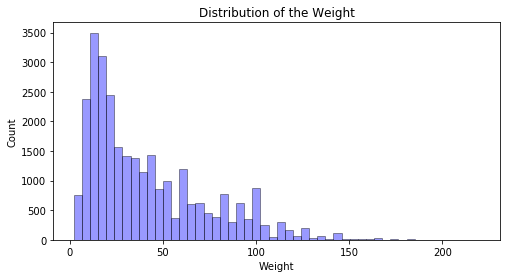

In [17]:
# distribution of weight column
plt.figure(figsize=(8,4))
ax = sns.distplot(data_cleaned['weight'], hist=True, kde=False, color = 'blue',
                  hist_kws={'edgecolor':'black'})
ax.set(xlabel='Weight', ylabel='Count', title='Distribution of the Weight')
plt.show()

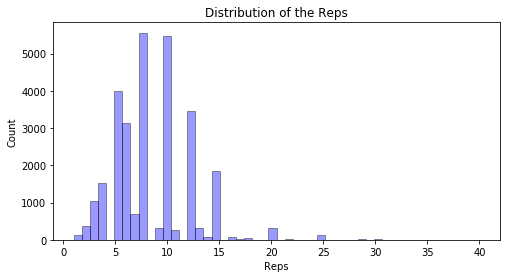

In [18]:
# distribution of reps column
plt.figure(figsize=(8,4))
ax = sns.distplot(data_cleaned['reps'], hist=True, kde=False, color = 'blue',
                  hist_kws={'edgecolor':'black'})
ax.set(xlabel='Reps', ylabel='Count', title='Distribution of the Reps')
plt.show()

The distribution of Weight and Reps columns are normal. The plot of Weight is right-skewed since many people use light weights to workout. The plot of Reps is like a bell shape since different people have their repetitions habit.

#### Categorical Data

The next step is to look at categorical data. We need to see how many unique values in each column and their distribution. To find the abnormal data, we need to group by the categorical data and see the pattern of the distribution plot.

In [19]:
# number of unique values for each column
for column in data_cat:
    print('%s: %d unique values' % (column, data_cleaned[column].nunique()))

workoutId: 6121 unique values
exerciseId: 9 unique values
singleSetId: 28819 unique values
exerciseName: 9 unique values
fake_user_id: 97 unique values


One thing that catches our attention is that the singleSetId is not unique since there are 28875 rows in the dataset but the number of unique singleSetId is 28820.

In [20]:
# select duplicates single set id rows
duplicated_set = data_cleaned['singleSetId'][data_cleaned['singleSetId'].duplicated() == True]
data_duplicated_set = data_cleaned[data_cleaned['singleSetId'].isin(duplicated_set)].sort_values('singleSetId')

# check duplicates rows for these duplicated single set id
# data_duplicated_set.groupby('singleSetId').nunique()

# look at some example of these duplicates
data_cleaned[(data_cleaned['fake_user_id'] == 'fake_id_460') &
             (data_cleaned['singleSetId'].isin(duplicated_set))].sort_values(['singleSetId']).head(6)

,Date,workoutId,exerciseId,singleSetId,exerciseName,reps,weight,fake_user_id
22013,2019-12-12,iKWQnPBy5d,ZAIuKpHvue,2Xxz3YPwWz,Dumbbell Lunge,8,9.071858,fake_id_460
22636,2019-12-12,vJa7JSDzgj,ZAIuKpHvue,2Xxz3YPwWz,Dumbbell Lunge,8,9.071858,fake_id_460
6817,2019-02-22,c7yyNfwNqC,mvkMgAdecH,3W9kRhSRz8,Dumbbell Shoulder Press,15,14.514973,fake_id_460
8875,2019-02-22,vx20BC4AEC,mvkMgAdecH,3W9kRhSRz8,Dumbbell Shoulder Press,15,14.514973,fake_id_460
22542,2019-12-12,vJa7JSDzgj,ZAIuKpHvue,NnnRAENuWf,Dumbbell Lunge,8,9.071858,fake_id_460
22923,2019-12-12,iKWQnPBy5d,ZAIuKpHvue,NnnRAENuWf,Dumbbell Lunge,8,9.071858,fake_id_460


One explaination of these duplicates single set id is that if on the same day, a user does a second workout with an exercise that was done in the first workout, the singleSetId will be the same. Up to now, this issue doesn't affect our analysis but we need to keep it in mind.

Since there are only nine types of exercises, we can also have a look at the distribution to find whether there are abnormal data.

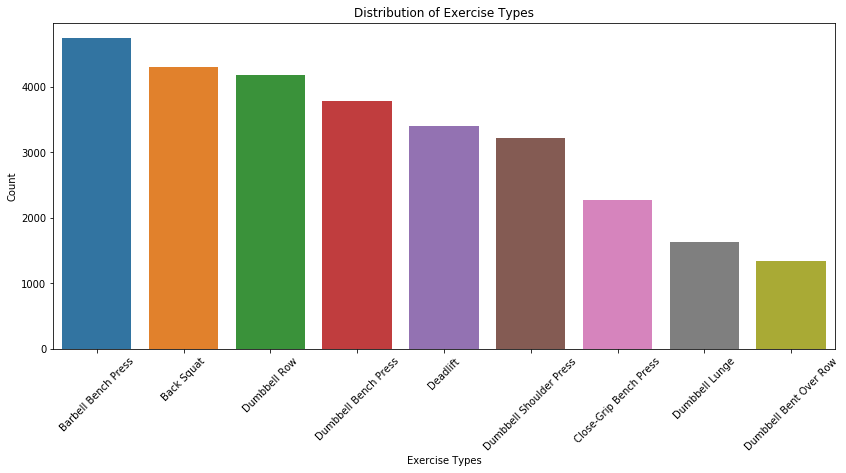

In [21]:
# distribution of each exercise types
plt.figure(figsize=(14,6))
ax = sns.countplot(x='exerciseName', data=data_cleaned, order = data_cleaned['exerciseName'].value_counts().index)
ax.set(xlabel='Exercise Types', ylabel='Count', title='Distribution of Exercise Types')
plt.xticks(rotation=45)
plt.show()

The distribution of exercise types is reasonable.

## Data Manipulation <a class="anchor" id="dc"></a>
**[Back to top](#toc)**

The original dataset is in a single set level, which means that each row is a single set. To perform data explorative analysis thoroughly, we need to aggregate the dataset by a date level (each row is a unique date) and a user-level (each row is a unique user). Here are different levels and what kind of attributes in those levels.
    
    1. Date Level: Number of Users, Number of Workouts, Number of Single Set, Average Single Set per User
    2. User Level: Number of Active Days, Number of Workouts, Number of Single Set, Average Weight, Average Reps, Recency, Average Volume Improvement, Average Usage Gap, Usage Gap Variance

### Date Level

In [22]:
# group by date
data_date = data_cleaned.groupby('Date').agg({'workoutId' : 'nunique', 'singleSetId' : 'count', 
                                              'fake_user_id' : 'nunique'}).reset_index()
data_date = data_date.rename(columns={"workoutId": "numofWorkout", "singleSetId": "numofSingleSet", 
                                      "fake_user_id" : "numofUser"})
# add an average workout column
data_date['avgSingleSet'] = data_date['numofSingleSet'] / data_date['numofUser']
data_date.head()

,Date,numofWorkout,numofSingleSet,numofUser,avgSingleSet
0,2017-12-23,1,3,1,3.0
1,2017-12-27,1,2,1,2.0
2,2018-01-01,1,4,1,4.0
3,2018-01-04,1,3,1,3.0
4,2018-01-06,1,5,1,5.0


### User Level

In [23]:
# create average volume improvement column
data_cleaned['volume'] = data_cleaned['reps'] * data_cleaned['weight']
data_userImprove = data_cleaned.groupby(['fake_user_id', 'Date', 'exerciseName'])['volume'].mean().reset_index()

data_first = data_userImprove.sort_values('Date').groupby(['fake_user_id', 'exerciseName']).first().reset_index()
data_first = data_first.rename(columns={"Date": "firstDate", "volume": "firstVolumn"})
data_last = data_userImprove.sort_values('Date').groupby(['fake_user_id', 'exerciseName']).last().reset_index()
data_last = data_last.rename(columns={"Date": "lastDate", "volume": "lastVolumn"})

data_userImprove = data_first.merge(data_last, on=['fake_user_id', 'exerciseName'])
data_userImprove['improvement'] = (data_userImprove['lastVolumn'] - data_userImprove['firstVolumn']) / \
                                   data_userImprove['firstVolumn']
data_userImprove['improvement'] = np.where(data_userImprove['firstDate'] == data_userImprove['lastDate'], 
                                           np.nan, data_userImprove['improvement'])
data_userImprove = data_userImprove.groupby('fake_user_id')['improvement'].mean().reset_index()

In [24]:
# create average gap and average gap variance columns
data_userVisit = data_cleaned.groupby(['fake_user_id', 'Date']).size().reset_index(name='count')
data_userVisit['previousUsage'] = data_userVisit.groupby('fake_user_id')['Date'].shift()
data_userVisit['daysBwUsage'] = data_userVisit['Date'] - data_userVisit['previousUsage']
data_userVisit['daysBwUsage'] = data_userVisit['daysBwUsage'].apply(lambda x: x.days)
data_userVisit = data_userVisit.groupby('fake_user_id')['daysBwUsage'].agg(['mean', 'std']).reset_index()
data_userVisit = data_userVisit.rename(columns={"mean": "averageUsageGap", "std": "UsageGapVariance"})

In [25]:
# create a recency column
most_recent_date = data_cleaned['Date'].max()
data_cleaned['recency'] = (most_recent_date - data_cleaned['Date']).dt.days

In [26]:
# create number of active days, number of workout, number of single set, number of exercise, average weight, average reps
data_user = data_cleaned.groupby('fake_user_id').agg({'Date' : 'nunique', 'workoutId' : 'nunique', 'singleSetId' : 'count', 
                                                      'exerciseId' : 'nunique', 'weight' : 'mean', 'reps' : 'mean',
                                                      'recency' : 'min'}).reset_index()
data_user = data_user.rename(columns={"Date": "numofActiveDays", "workoutId": "numofWorkout", "singleSetId" : "numofSingleSet",
                                     "exerciseId": "numofExercise", "reps": "avgReps", "weight": "avgWeight"})

In [27]:
# get final user level data
data_user = data_user.merge(data_userImprove, on='fake_user_id')
data_user = data_user.merge(data_userVisit, on='fake_user_id')
data_user = data_user[['fake_user_id', 'numofActiveDays', 'recency','numofWorkout','numofSingleSet','numofExercise',
         'avgWeight','avgReps','improvement','averageUsageGap','UsageGapVariance']]
data_user.head()

,fake_user_id,numofActiveDays,recency,numofWorkout,numofSingleSet,numofExercise,avgWeight,avgReps,improvement,averageUsageGap,UsageGapVariance
0,fake_id_399,184,152,185,822,9,30.385759,7.945255,0.600829,4.120219,3.707251
1,fake_id_400,382,0,388,1915,9,75.121855,8.738903,0.283869,2.359580,5.786949
2,fake_id_401,133,1,137,562,9,60.359334,7.624555,0.690362,4.712121,14.377426
3,fake_id_402,151,70,155,709,8,28.453519,8.799718,0.741614,2.013333,1.972926
4,fake_id_403,118,189,121,741,9,28.597849,8.032389,0.888833,3.085470,1.905404


## Exploratary Data Analysis <a class="anchor" id="eda"></a>
**[Back to top](#toc)**

### How Covid-19 Affect User Behaviors?

Covid-19 pandemic affects fitness industry significantly since most people stay at home and don't have a chance to go to the gym. Fitbod is not an exception. Even though Fitbod is a mobile App, daily users dropped after the Covid-19 outbreak. In Q2 2020, average daily users dropped by 36.04% compared to Q2 2019 and by 38.40% compared to Q1 2020. However, the average single sets per user every day keeps the same (~5 sets per user). It shows that before and after the Covid-19 outbreak, the workout intensity of the user remains the same, but the number of total users goes down. One recommendation to win back churn users is to sending coupons and notification. From the product perspective, we can also launch at-home exercise features such as introducing more videos to teach users how to workout at home without equipment.

Let's look at the change in terms of the type of exercises. I choose two periods of data (Q2 2019 and Q2 2020) to analyze since I want to remove the seasonality effect. For most of the exercise types, the number of exercises people do every day went down. On average, exercises required barbell dropped 48.64% while those required dumbbells dropped 18.66%. People at home don't have opportunities to use complex and heavy equipment. Therefore, we can introduce more exercises with light equipment such as dumbbell to encourage people to do workouts at home. To our surprise, the number of Dumbbell Shoulder Press people did increased by 64.44%. Since the sample size is small and the number of times people did Dumbbell Shoulder Press in Q2 2019 was only 45, we need to be cautious about it. If the dataset is larger, we are able to get a more accurate result for user behaviors.


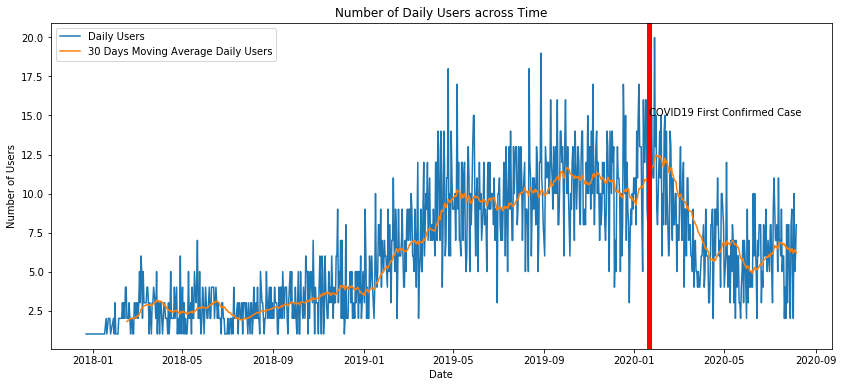

In [28]:
# Number of Users across Time

# create a moving average column
data_date['numofUser_ma_30'] = data_date['numofUser'].rolling(30).mean()

# create a Covid19 first confirmed case date
covid19_first_cases = pd.to_datetime('2020-01-20')

# plot
plt.figure(figsize=(14,6))
ax = sns.lineplot(x=data_date['Date'], y=data_date['numofUser'], label = 'Daily Users')
ax = sns.lineplot(x=data_date['Date'], y=data_date['numofUser_ma_30'], label = '30 Days Moving Average Daily Users')
plt.axvline(covid19_first_cases, color = 'r', linewidth = 5)
ax.text(covid19_first_cases, y=15, s='COVID19 First Confirmed Case', alpha=1, color='black')
ax.set(xlabel='Date', ylabel='Number of Users', title='Number of Daily Users across Time')
plt.show()

The number of daily active users dropped significantly after Covid-19 first confirmed case.

In [29]:
# compare the performance of Q2 2020 with other time windows (Q1 2020 and Q2 2019)

# Q2 comparison
Q22020_dailyUsers = data_date[(data_date['Date'] < '2020-07-01') & (data_date['Date'] >= '2020-04-01')]['numofUser'].mean()
Q22019_dailyUsers = data_date[(data_date['Date'] < '2019-07-01') & (data_date['Date'] >= '2019-04-01')]['numofUser'].mean()
Q2drop = abs(Q22020_dailyUsers - Q22019_dailyUsers) / Q22019_dailyUsers * 100

# Q1 Q2 comparison
Q12020_dailyUsers = data_date[(data_date['Date'] < '2020-04-01') & (data_date['Date'] >= '2020-01-01')]['numofUser'].mean()
Q1Q2drop = abs(Q22020_dailyUsers - Q12020_dailyUsers) / Q12020_dailyUsers * 100

print('In Q2 2020, average daily users dropped by %2.2f%% compared to Q2 2019.' % Q2drop)
print('In Q2 2020, average daily users dropped by %2.2f%% compared to Q1 2020.' % Q1Q2drop)

In Q2 2020, average daily users dropped by 36.04% compared to Q2 2019.
In Q2 2020, average daily users dropped by 38.40% compared to Q1 2020.


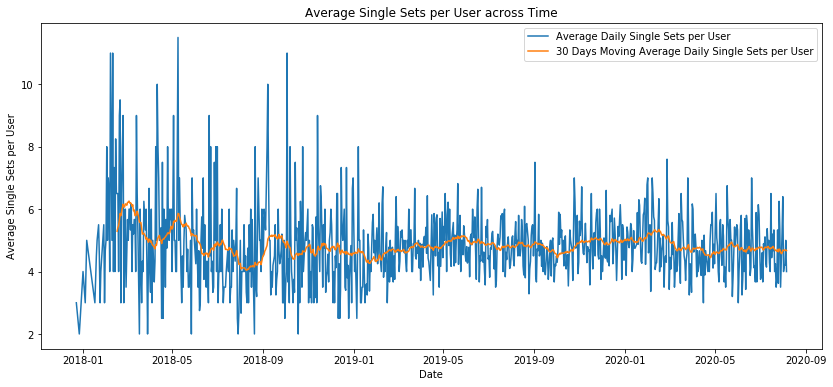

In [30]:
# Daily Average Single Sets per User across Time

# create a moving average column
data_date['avgSingleSet_ma_30'] = data_date['avgSingleSet'].rolling(30).mean()

# plot
plt.figure(figsize=(14,6))
ax = sns.lineplot(x=data_date['Date'], y=data_date['avgSingleSet'], label = 'Average Daily Single Sets per User')
ax = sns.lineplot(x=data_date['Date'], y=data_date['avgSingleSet_ma_30'], 
                  label = '30 Days Moving Average Daily Single Sets per User')
ax.set(xlabel='Date', ylabel='Average Single Sets per User', title='Average Single Sets per User across Time')
plt.show()

Even though the number of daily active users dropped, the number of single sets remained the same. Therefore, active users' behaviors are the same so our goal is to win back churn customers.

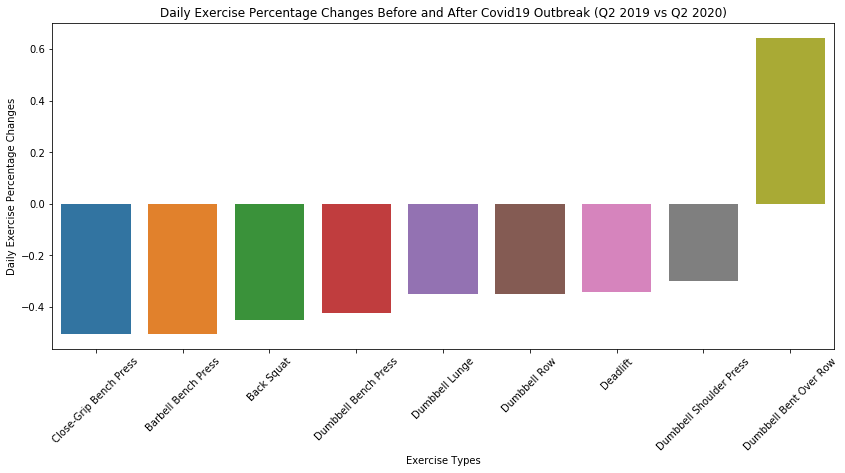

In [31]:
# look at the difference exercise people like before and after Covid-19

# create an exercise level data
data_exercise = data_cleaned.groupby(['Date', 'fake_user_id', 'exerciseName']).size().reset_index(name='count')
data_exercise = data_exercise.groupby(['Date', 'exerciseName']).size().reset_index(name='numofUser')

# filter the data
data_exercise = data_exercise[((data_exercise['Date'] < '2019-07-01') & (data_exercise['Date'] >= '2019-04-01')) | \
                              ((data_exercise['Date'] < '2020-07-01') & (data_exercise['Date'] >= '2020-04-01'))]

# create a column to indentify before or after Covid-19
data_exercise['beforeCovid19'] = np.where(data_exercise['Date'] < covid19_first_cases, 1, 0)

# compute the statistics
data_exercise = data_exercise.groupby(['exerciseName', 'beforeCovid19'])['numofUser'].sum().reset_index(name='count')
data_exercise = data_exercise.pivot(index='exerciseName',columns='beforeCovid19',values='count').reset_index()
data_exercise = data_exercise.rename(columns={0: "afterCovid19", 1: "beforeCovid19"})
data_exercise.columns.name = None
data_exercise['percChange'] = (data_exercise['afterCovid19'] - data_exercise['beforeCovid19']) / data_exercise['beforeCovid19']

# distribution of each exercise
plt.figure(figsize=(14,6))
ax = sns.barplot(x='exerciseName', y='percChange', data=data_exercise, 
                 order = data_exercise.sort_values('percChange').exerciseName)
ax.set(xlabel='Exercise Types', ylabel='Daily Exercise Percentage Changes', 
       title='Daily Exercise Percentage Changes Before and After Covid19 Outbreak (Q2 2019 vs Q2 2020)')
plt.xticks(rotation=45)
plt.show()

On average, exercises required barbell dropped more significantly than those required dumbbells.

In [32]:
# show the drop of the number of exercises in different equipment requirement

# create a list to identify the requirment
barbell_list = ['Close-Grip Bench Press', 'Barbell Bench Press', 'Back Squat']
dumbbell_list = ['Deadlift', 'Dumbbell Bench Press', 'Dumbbell Bent Over Row',
                 'Dumbbell Lunge', 'Dumbbell Row', 'Dumbbell Shoulder Press']

# exercise required barbell
barbell_drop = data_exercise[data_exercise['exerciseName'].isin(barbell_list)]['percChange'].mean() * 100

# exercise required barbell
dumbbell_drop = data_exercise[data_exercise['exerciseName'].isin(dumbbell_list)]['percChange'].mean() * 100

print('The average number of exercises related to barbell dropped by %2.2f%% compared to Q2 2019.' % barbell_drop)
print('The average number of exercises related to dumbbell dropped by %2.2f%% compared to Q2 2019.' % dumbbell_drop)

The average number of exercises related to barbell dropped by -48.64% compared to Q2 2019.
The average number of exercises related to dumbbell dropped by -18.66% compared to Q2 2019.


### What do Customers Look Like?

Customers matter. As a subscription business, fitbod needs to focus on usage frequency and user recency. The more frequently a user uses our App, the more likely he/she will subscribe to our App. Understanding when a user uses our App last time can help us design promotion plans to win back our customers. Valuable customers are those with high frequency and low recency. In the user-level data, we focus on the number of active days of a user and user recency to see what do our customers look like.

When we look at the distribution of the number of active days and recency, we find that many users (~54.64%) have recency greater than three months. In other words, 54.64% of the users did not use our App in the last three months. The distribution of the number of active days is highly right-skewed, which means that most users have a low frequency to use the App.

The number of exercises a user tries, the average weight of a user's single set, and improvement are three key factors that have a positive relationship with the number of active days. However, it is dangerous to say these factors result in more active days since there may be simultaneity bias since the more active days a user is, the more likely he/she will improve. Another interesting finding is that the variance of the usage gap is negatively related to the number of active days. In other words, the number of active days is related to the habit of users' usage. It is helpful to further analyze why people change their workout habits and improve our products.

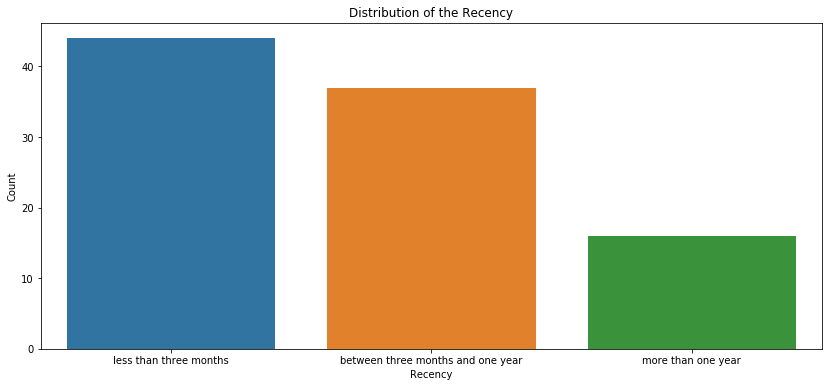

In [33]:
# distribution of user's recency

data_user['recencyCat'] = data_user['recency']
data_user['recencyCat'] = np.where(data_user['recency'] < 90, 'less than three months',
                                           data_user['recencyCat'])
data_user['recencyCat'] = np.where((90 <= data_user['recency']) & (365 >= data_user['recency']),
                                           'between three months and one year',
                                           data_user['recencyCat'])
data_user['recencyCat'] = np.where(365 < data_user['recency'],
                                           'more than one year',
                                           data_user['recencyCat'])
plt.figure(figsize=(14,6))
ax = sns.countplot(x='recencyCat', data=data_user,
                   order = data_user['recencyCat'].value_counts().index)
ax.set(xlabel='Recency', ylabel='Count', title='Distribution of the Recency')
plt.show()

In [34]:
# get the proportion of users who did not use our App in last three months

usersThreeMonthProp = data_user[data_user['recency'] >= 90].shape[0] / data_user.shape[0] * 100
print('The proportion of users who did not use our App in last three months is %2.2f%%.' % usersThreeMonthProp)

The proportion of users who did not use our App in last three months is 54.64%.


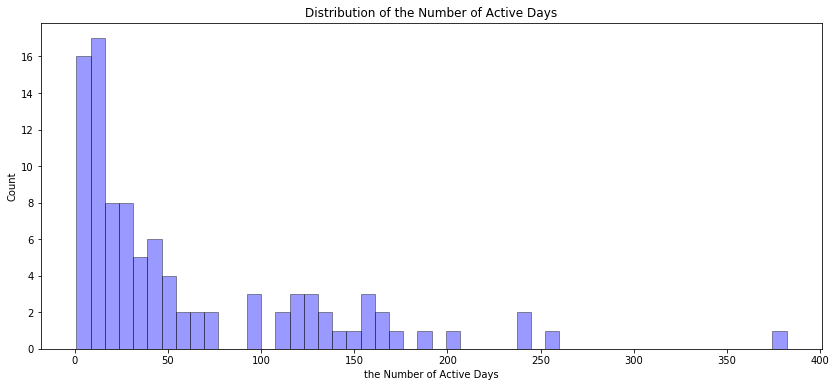

In [35]:
# distribution of the number of active days
plt.figure(figsize=(14,6))
ax = sns.distplot(data_user['numofActiveDays'], hist=True, kde=False, color = 'blue', bins = 50,
                  hist_kws={'edgecolor':'black'})
ax.set(xlabel='the Number of Active Days', ylabel='Count', title='Distribution of the Number of Active Days')
plt.show()

In [36]:
# define correlation heatmap function
def correlation_heatmap(df, column_list):
    plt.figure(figsize=(8,6))
    correlation = df[column_list]
    sns.heatmap(correlation.corr(), annot = True)
    plt.title('Correlation Heatmap')

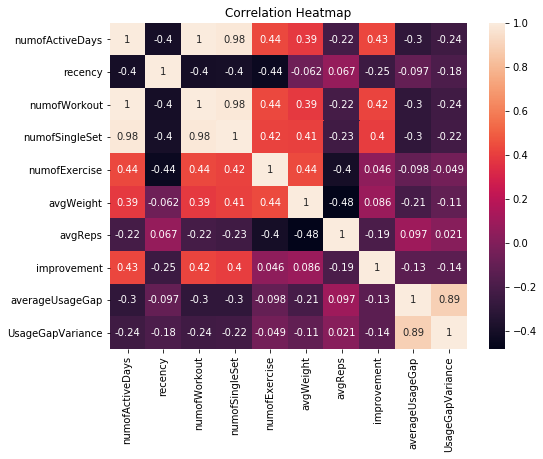

In [37]:
# create correlation heatmap
correlation_heatmap(data_user, data_user.columns)

##  User Churn Prediction  <a class="anchor" id="ucp"></a>
**[Back to top](#toc)**

One business goal of Fitbod is to reduce the churn rate. If we are able to know whether a user will churn next month, we can act in advance. For example, we can provide no promotional offer to customers that will be active next month since he/she will use our App anyways. We can nudge the user with marketing if there is no usage in next month.

In this dataset, the most recent date is 8/6/2020 and we assume that the current date is one month before (7/7/2020). I create a new column to identify whether a user will use our App in the next month. The definition of all variables I use is as follows:
    
**Target Variables**
    
    churn: Whether a user uses our App next month (from 7/7/2020 to 8/6/2020)
    
**Independent Variables**

    numofActiveDays: The total number of date a user used our App
    numofWorkout: The total number of workouts a user did
    numofSingleSet: The total number of single sets a user did
    numofExercise: The total number of exercises a user did
    avgWeight: The average weight of all single sets a user did
    avgReps: The average reps of all single sets a user did
    recency: Days between the date a user last used our App and the current date (7/7/2020)
    improvement: The average percentage change of the volume (weight * reps) of each exercise from the first date to the last date
    averageUsageGap: The average days between each usage 
    UsageGapVariance: The variance of days between each usage

**How to prep training data**

The dataset is a little bit unbalanced. To get a similar distribution, I stratify the dataset based on the class values and then split to train (70%) and test (30%) data. 

**Why this model**

This is a binary classification problem. I use a random forest to predict whether a user will churn next month. Random Forest is an ensemble bagging algorithm to achieve low prediction error. It reduces the variance of the individual decision trees by randomly selecting trees and then either average them or picking the class that gets the most vote. It is a flexible, easy to use machine learning algorithm that produces, even without hyper-parameter tuning, a great result most of the time. I use auc of roc (Area under the receiver operating characteristic curve) to measure the model's performance. It is between 0 and 1. The more auc of roc is close to 1, the better the result is. It is equivalent to the probability that a randomly chosen positive instance will be ranked ahead of a randomly chosen negative instance.

**How this model preformed**

Here we evaluate our model. The auc of roc of the best model is 0.84. The precision for churn customers is 0.85 and the recall for churn customers is 0.94. We capture a lot of positive examples but some of those we predict as positive are actually negative.

**What if I received a larger dataset**

If I get a larger dataset, the distribution of the target variable class values may likely be more unbalanced. One solution is to resample the dataset such as over-sampling or under-sampling to correct for imbalances. Another solution is to penalize the classification model by imposing an additional cost for making classification mistakes on the minority class during training. A large dataset means that it is more computationally expensive. I will change the hyperparameters tuning process such as reduce the fold of cross-validation and the number of hyperparameter combinations to reduce training time. Another solution is that I will consider using big data tools such as Spark, AWS, or Azure to build up the model in the cloud.

### Data Preprocessing

Here I filter the data that was one month ago and created features and label for modeling.

In [38]:
# filter data by previous 30 days
previous30Days = data_cleaned['Date'].max() + timedelta(days=-30)
data_cleaned_30 = data_cleaned[data_cleaned['Date'] < previous30Days]

# create average volumn improvement column
data_cleaned_30['volumn'] = data_cleaned_30['reps'] * data_cleaned_30['weight']
data_userImprove_30 = data_cleaned_30.groupby(['fake_user_id', 'Date', 'exerciseName'])['volumn'].mean().reset_index()

data_first_30 = data_userImprove_30.sort_values('Date').groupby(['fake_user_id', 'exerciseName']).first().reset_index()
data_first_30 = data_first_30.rename(columns={"Date": "firstDate", "volumn": "firstVolumn"})
data_last_30 = data_userImprove_30.sort_values('Date').groupby(['fake_user_id', 'exerciseName']).last().reset_index()
data_last_30 = data_last_30.rename(columns={"Date": "lastDate", "volumn": "lastVolumn"})

data_userImprove_30 = data_first_30.merge(data_last_30, on=['fake_user_id', 'exerciseName'])
data_userImprove_30['improvement'] = (data_userImprove_30['lastVolumn'] - data_userImprove_30['firstVolumn']) / \
                                   data_userImprove_30['firstVolumn']
data_userImprove_30['improvement'] = np.where(data_userImprove_30['firstDate'] == data_userImprove_30['lastDate'], 
                                           np.nan, data_userImprove_30['improvement'])
data_userImprove_30 = data_userImprove_30.groupby('fake_user_id')['improvement'].mean().reset_index()

# create average gap and average gap variance columns
data_userVisit_30 = data_cleaned_30.groupby(['fake_user_id', 'Date']).size().reset_index(name='count')
data_userVisit_30['previousUsage'] = data_userVisit_30.groupby('fake_user_id')['Date'].shift()
data_userVisit_30['daysBwUsage'] = data_userVisit_30['Date'] - data_userVisit_30['previousUsage']
data_userVisit_30['daysBwUsage'] = data_userVisit_30['daysBwUsage'].apply(lambda x: x.days)
data_userVisit_30 = data_userVisit_30.groupby('fake_user_id')['daysBwUsage'].agg(['mean', 'std']).reset_index()
data_userVisit_30 = data_userVisit_30.rename(columns={"mean": "averageUsageGap", "std": "UsageGapVariance"})

# create a recency column
most_recent_date_30 = data_cleaned_30['Date'].max()
data_cleaned_30['recency'] = (most_recent_date_30 - data_cleaned_30['Date']).dt.days

# create number of active days, number of workout, number of single set, number of exercise, average weight, average reps
data_user_30 = data_cleaned_30.groupby('fake_user_id').agg({'Date' : 'nunique', 'workoutId' : 'nunique', 'singleSetId' : 'count', 
                                                      'exerciseId' : 'nunique', 'weight' : 'mean', 'reps' : 'mean',
                                                      'recency' : 'min'}).reset_index()
data_user_30 = data_user_30.rename(columns={"Date": "numofActiveDays", "workoutId": "numofWorkout", 
                                            "singleSetId" : "numofSingleSet","exerciseId": "numofExercise", 
                                            "reps": "avgReps", "weight": "avgWeight"})

# get final user level data
data_user_30 = data_user_30.merge(data_userImprove_30, on='fake_user_id')
data_user_30 = data_user_30.merge(data_userVisit_30, on='fake_user_id')
data_user_30 = data_user_30[['fake_user_id', 'numofActiveDays', 'recency','numofWorkout','numofSingleSet','numofExercise',
         'avgWeight','avgReps','improvement','averageUsageGap','UsageGapVariance']]

# add label
not_churn_users = data_cleaned[data_cleaned['Date'] >= previous30Days].fake_user_id.unique()
data_user_30['churn'] = np.where(data_user_30['fake_user_id'].isin(not_churn_users), 0, 1)

# here we drop eight rows (users with only one usage or users only do each exercise one time 
# missing_values(data_user_30)
# data_user_30[data_user_30.isna().any(axis=1)]
data_user_30 = data_user_30.dropna()

data_user_30.head()

,fake_user_id,numofActiveDays,recency,numofWorkout,numofSingleSet,numofExercise,avgWeight,avgReps,improvement,averageUsageGap,UsageGapVariance,churn
0,fake_id_399,184,121,185,822,9,30.385759,7.945255,0.600829,4.120219,3.707251,1
1,fake_id_400,373,4,379,1871,9,74.972047,8.709246,0.145030,2.322581,5.841872,0
2,fake_id_401,116,0,120,479,9,61.130877,7.549061,0.673554,5.147826,15.355577,0
3,fake_id_402,151,39,155,709,8,28.453519,8.799718,0.741614,2.013333,1.972926,1
4,fake_id_403,118,158,121,741,9,28.597849,8.032389,0.888833,3.085470,1.905404,1


In [39]:
# correlation with target variable
target_variable = 'churn'
correlations = data_user_30.corr()
target_correlations = correlations[target_variable].sort_values()
target_correlations = target_correlations.drop(labels=[target_variable])
target_correlations

numofSingleSet     -0.486589
numofWorkout       -0.465841
numofActiveDays    -0.460225
improvement        -0.324472
UsageGapVariance   -0.185241
numofExercise      -0.172890
avgWeight          -0.145166
averageUsageGap    -0.091535
avgReps             0.142130
recency             0.464449
Name: churn, dtype: float64

As we can see, all these independent variables are correlated with target variable 'churn'. Therefore, I use all of them to build a machine learning model.

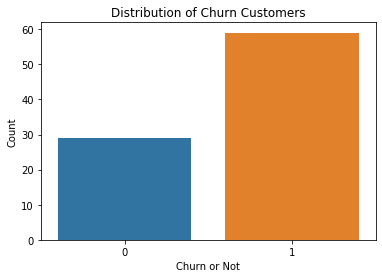

In [40]:
# have a look at the distribution of target variable churn
ax = sns.countplot(x='churn', data=data_user_30)
ax.set(xlabel='Churn or Not', ylabel='Count', title='Distribution of Churn Customers')
plt.show()

The dataset is a little bit unbalanced. In order to get a similar distribution, we need to stratify the dataset based on the class values and then split the train and test data. 

### Modeling

In [41]:
# define the target variable and independent variables
y=data_user_30['churn']
X=data_user_30.drop(['churn','fake_user_id'],axis=1)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state = 1, stratify = y)

In [42]:
# define the modeling pipeline
def modeling_pipeline(X_train_data, X_test_data, y_train_data, 
                      model, param_grid, cv=10, scoring_fit=make_scorer(roc_auc_score)):
    fitted_model = None
    
    cv = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=1, 
        scoring=scoring_fit,
        verbose=0
    )
    fitted_model = cv.fit(X_train_data, y_train_data)
    
    return fitted_model

In [43]:
# use random forest to modeling
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15,20,30],
    'max_leaf_nodes': [50, 100, 150]
}

result = modeling_pipeline(X_train, X_test, y_train, model, 
                              param_grid, cv=5, scoring_fit=make_scorer(roc_auc_score))

print('ROC for random forest model is: %2.2f.' % result.best_score_)

ROC for random forest model is: 0.85.


              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.85      0.94      0.89        18

    accuracy                           0.85        27
   macro avg       0.85      0.81      0.82        27
weighted avg       0.85      0.85      0.85        27



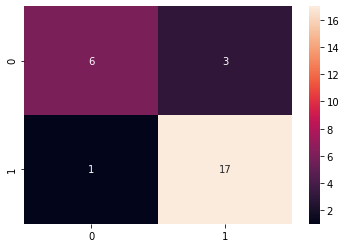

In [44]:
# get the confusion matrix
cm = confusion_matrix(y_test,result.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

# print the classification result
print(classification_report(y_test,result.predict(X_test)))